# Sample registration of an image to patterns

Since thre is still an deformation among input images and its representation we look for a descriptive transformations...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import time
import copy
import numpy as np
import matplotlib.pylab as plt
import SimpleITK as sitk

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from bpdl import data_utils as tl_data
import notebooks.notebook_utils as nb_utils

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Input images

In [2]:
# STATIC IMAGE - from atlas
img_static, img_moving = nb_utils.generate_synth_image_pair_simple()
img_static_fuzzy = tl_data.image_transform_binary2fuzzy(img_static, coef=0.2)
img_moving_fuzzy = tl_data.image_transform_binary2fuzzy(img_moving, coef=0.2)

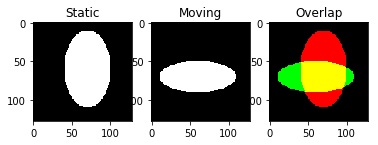

In [3]:
plt.subplot(1, 3, 1), plt.imshow(img_static, cmap=plt.cm.Greys_r), plt.title('Static')
plt.subplot(1, 3, 2), plt.imshow(img_moving, cmap=plt.cm.Greys_r), plt.title('Moving')
im_overlap = np.rollaxis(np.array([img_static, img_moving, np.zeros(img_static.shape)]), 0, 3)
_= plt.subplot(1, 3, 3), plt.imshow(im_overlap), plt.title('Overlap')

## Bspline

This [example1](https://itk.org/SimpleITKDoxygen/html/ImageRegistrationMethodBSpline2_2ImageRegistrationMethodBSpline2_8py-example.html) and [example2](https://itk.org/SimpleITKDoxygen/html/ImageRegistrationMethodBSpline1_2ImageRegistrationMethodBSpline1_8py-example.html) illustrates how to use the classic ...

In [4]:
def warp_itk_bspline(img, transform):
    image = sitk.GetImageFromArray(img)
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(transform)
    
    warped = resampler.Execute(image)
    return warped

In [5]:
def regsiter_itk_bsplines(img_static, img_moving):
    fixed = sitk.GetImageFromArray(img_static.astype(float))
    moving = sitk.GetImageFromArray(img_moving.astype(float))

    transformDomainMeshSize = [15] * moving.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize, order=3)
    
    regist = sitk.ImageRegistrationMethod()
    # regist.SetMetricAsDemons(0.001)
    regist.SetMetricAsMeanSquares()
    regist.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                                numberOfIterations=150,
                                maximumNumberOfCorrections=5,
                                maximumNumberOfFunctionEvaluations=100,
                                costFunctionConvergenceFactor=1e+5)
    # regist.SetOptimizerScalesFromPhysicalShift( )
    regist.SetInitialTransform(tx)
    regist.SetInterpolator(sitk.sitkLinear)
    
    regist.SetShrinkFactorsPerLevel([6, 2, 1])
    regist.SetSmoothingSigmasPerLevel([8, 2, 0])
    
    # regist.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
    # regist.AddCommand( sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R) )
    
    t = time.time()
    transform = regist.Execute(fixed, moving)
    print('registration took:', time.time() - t)

    # print(transform)
    print("Optimizer stop condition: {0}".format(regist.GetOptimizerStopConditionDescription()))
    print(" Iteration: {0}".format(regist.GetOptimizerIteration()))
    print(" Metric value: {0}".format(regist.GetMetricValue()))
    return transform

## Experiments

Particular experiments with registering several inout images to static (binary) image

Register: **static <- moving** image

registration took: 2.530557155609131
Optimizer stop condition: LBFGSBOptimizerv4: Gradient tolerance reached. Gradient tolerance is 1e-05
 Iteration: 36
 Metric value: 0.00034404003450229554


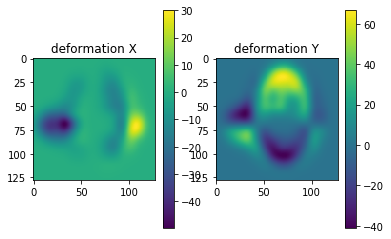

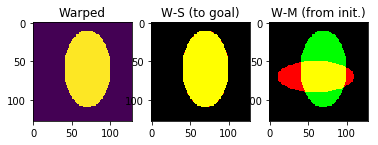

In [8]:
transform = regsiter_itk_bsplines(img_static, img_moving)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_bspline(img_moving, transform)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

Register: **static <- static FUZZY** image

registration took: 0.6511080265045166
Optimizer stop condition: LBFGSBOptimizerv4: Gradient tolerance reached. Gradient tolerance is 1e-05
 Iteration: 7
 Metric value: 0.0041699177100000765


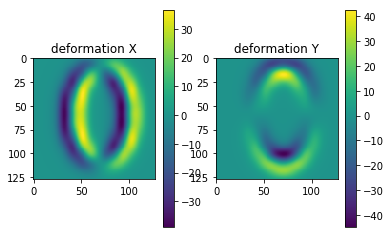

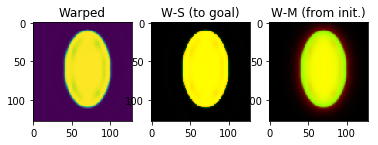

In [9]:
transform = regsiter_itk_bsplines(img_static, img_static_fuzzy)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_bspline(img_static_fuzzy, transform)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_static_fuzzy)

Register: **static <- moving FUZZY** image

registration took: 0.9841773509979248
Optimizer stop condition: LBFGSBOptimizerv4: Gradient tolerance reached. Gradient tolerance is 1e-05
 Iteration: 9
 Metric value: 0.00667421108724665


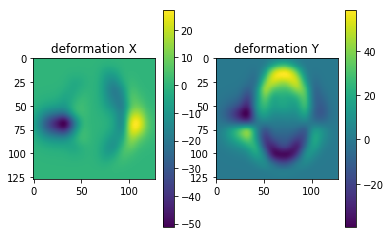

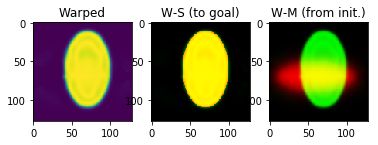

In [10]:
transform = regsiter_itk_bsplines(img_static, img_moving_fuzzy)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_bspline(img_moving_fuzzy, transform)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving_fuzzy)